# "You Snooze, You Win" Challenge

Every year, the [PhysioNet/CinC (Computing in Cardiology) Challenge](https://www.physionet.org/challenge/) invites "participants to tackle clinically interesting problems that are either unsolved or not well-solved." As you may have figured out from the title, this year's challenge focuses on sleep, particularly the classification of nonarousal and arousal timeframes. If you would like to understand the biological implications of the challenge, we recommend reading PhysioNet's [introduction](https://physionet.org/challenge/2018/) of the challenge.

For this challenge, you will classify samples into 5 classes (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of seven physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12000 timepoints). In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and 'score' your model.

In [0]:
### Run once ###

from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
tf.enable_eager_execution()

## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital’s Computational Clinical Neurophysiology Laboratory, and the Clinical Data Animation Laboratory.
***
**Class labels:**
- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM
***
**Class description:**

|Class|State|Characterizations|Brain Waves|Percentage of Sleep|
|-|-|-|-|-|-|
|Arousal|Consciousness|Wakefulness (coherent cognitive and behavioral responses to external stimuli)|Alpha, Beta|-|
|NREM1|Light sleep|Hypnic jerk (involuntary twitch that causes an individual to awaken for a moment)|Theta|5|
|NREM2|Unequivocal sleep|Sleep spindle (sudden burst of oscillatory brain activity); K-complex (delta wave that lasts for a second)|Theta, Delta|40-50|
|NREM3|Deep sleep|Parasomnias (sleep disorders such as sleepwalking and night terrors)|Delta|15-25|
|REM|Dreaming sleep|REM atonia (paralysis of nonessential skeletal muscles); Dreaming|Alpha, Beta|20-25|
***
**Physiological signal description:**

O2-M1 - posterior brain activity (electroencephalography)

E1-M2 - left eye activity (electrooculography)

Chin1-Chin2 - chin movement (electromyography)

ABD - abdominal movement (electromyography)

CHEST - chest movement (electromyography)

AIRFLOW - respiratory airflow

ECG - cardiac activity (electrocardiography)
***
Run both cell blocks to get the challenge data.

In [8]:
!git clone https://github.com/BeaverWorksMedlytics/datasets.git

Cloning into 'datasets'...
remote: Counting objects: 5076, done.
remote: Total 5076 (delta 0), reused 0 (delta 0), pack-reused 5076
Receiving objects: 100% (5076/5076), 439.02 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [0]:
os.chdir('./datasets/Week2_Challenge/')

## Data Visualization

Run the first cell once to store the training and test sample file locations. If the data have been imported correctly, the cell should output '4000' (training) and '1000' (test).

Run the second cell once to initialize important functions that you may find useful. Descriptions of input and output will be provided for every function in the notebook.

Run the last cell to visualize a random test sample's seven physiological signals in a raw and FFT (fast fourier transform) format. Note that you can change different parameters, which we will go over in detail.

It is important to recognize that the same signal from different samples in the same class may vary in terms of amplitude and frequency. Of course, this is a byproduct of intraspecies variation. Further data preprocessing and/or discriminatory feature extraction may be necessary to account for this phenomenon.

In [10]:
### Run once ###

def get_file_locs():
    file_dict = {'training':[], 'test':[]}
    for data_type in file_dict:
        for file in os.listdir('./' + data_type):
            file_dict[data_type].append(data_type + '/' + file)
    """ file_dict (dict) stores 'training' and 'test' as keys and sample file locations as values """
    return file_dict

file_dict = get_file_locs()
print(len(file_dict['training']), len(file_dict['test']))

4000 1000


In [0]:
### Run once ###

""" data_type (str) must be 'training' or 'test' """
def get_random_data(data_type): #
    rand_file = random.choice(file_dict[data_type])
    rand_sample = pd.read_pickle('./' + rand_file)
    """ rand_sample (pd dataframe) stores the complete sample data; rand_file.split('/')[1] (str) stores the sample number """
    return rand_sample, rand_file.split('/')[1]

""" data_type same as get_random_data() input; id_number (int) must be from 0-3999 for training or 0-999 for test """
def get_sample_data(data_type, id_number):
    file = './' + data_type + '/' + str(id_number) + '.xz'
    sample = pd.read_pickle('./' + file)
    """ sample and file.split('/')[2] same as get_random_data() output """
    return sample, file.split('/')[2]

""" sample (pd dataframe) must be output from get_random_data() or get_sample_data() """
def get_raw_signals(sample):
    raw_signals_x = np.arange(0, 60, step = 1/200)
    raw_signals_y = np.transpose(sample['Signal'][0])
    """ tuple: raw_signals_x (ndarray) stores raw signal timepoints in seconds; raw_signals_y (ndarray) stores all seven signals for every timepoint; 'Raw' (str) stores signal type """
    return (raw_signals_x, raw_signals_y, 'Raw')

""" sample same as get_raw_signals() input """
def get_fft_signals(sample):
    num_datapoints = len(sample['Signal'][0])
    fft_signals_x = np.arange(num_datapoints//2 + 1)/60
    fft_signals_y = np.ndarray(shape = (7, num_datapoints//2 + 1))
    for counter, signal in enumerate(np.fft.rfft(np.transpose(sample['Signal'][0]))):
        fft_signals_y[counter] = np.abs(signal)
    """ tuple: fft_signals_x (ndarray) stores fft signal frequencies in hertz; fft_signals_y (ndarray) stores amplitude for every frequency; 'FFT' stores signal type """
    return (fft_signals_x, fft_signals_y, 'FFT')

""" sample same as get_raw_signals() input """
def get_signals(sample):
    raw_signals = get_raw_signals(sample)
    fft_signals = get_fft_signals(sample)
    """ raw_signals and fft_signals same as get_raw_signals() and get_fft_signals() output, respectively """
    return raw_signals, fft_signals

""" signal_list (list) contains output (tuple) from get_raw_signals(), get_fft_signals(), or get_signals() """
def graph_signals(signal_list):
    num_type_signals = len(signal_list)
    plt.figure(figsize = (20, 18))
    for signal_format_index, signal_xy in enumerate(signal_list):
        for signal_index in range(7):
            plt.subplot(7, num_type_signals, num_type_signals*signal_index + signal_format_index + 1)
            if signal_index==0:
                plt.title(signal_xy[2])
            plt.plot(signal_xy[0], signal_xy[1][signal_index])
            plt.ylabel(sig_dict[signal_index])
        plt.xlabel(sig_type_dict[signal_format_index])
    plt.show()

""" Initalizes key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}

Test 413.xz (Unknown)


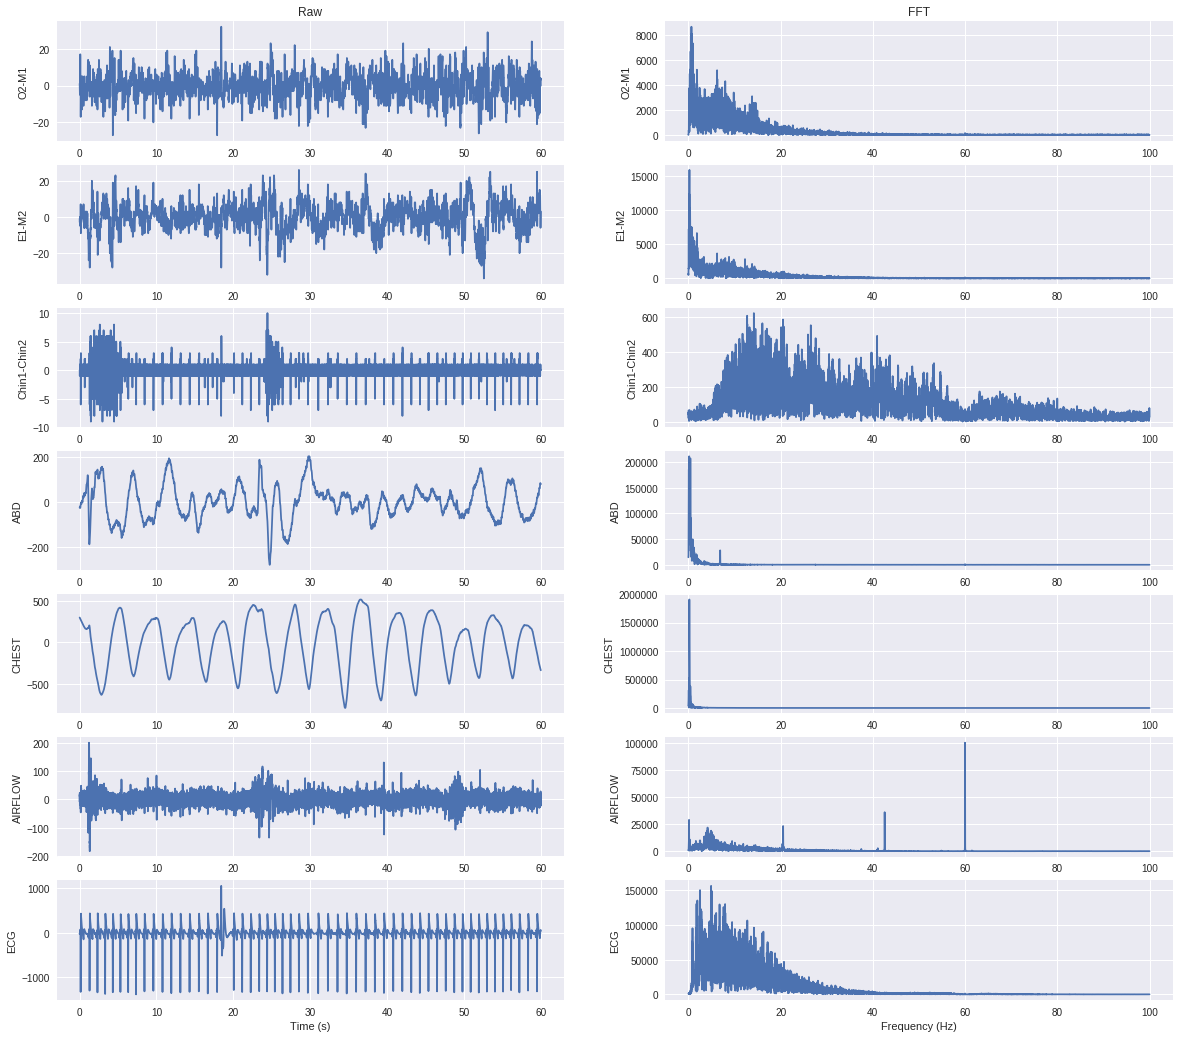

In [65]:
data_type = 'test'
sample, sample_id = get_random_data(data_type)
#sample, sample_id = get_sample_data(data_type, 0)
raw_signals, fft_signals = get_signals(sample)
if data_type == 'training': 
    print(data_type.title(), sample_id, '(' + stage_dict[int(sample_id.split('.')[0])//800] + ')')
else: 
    print(data_type.title(), sample_id, '(Unknown)')
graph_signals([raw_signals, fft_signals])

## Example Classifier

Below is an example of a poor classifier for this dataset. It is a simple neural network that takes the maximal, normalized variance for each signal (given a frame and interval) as its input features. After training, it performs with 44% accuracy on test data.

While the example classifier makes use of a neural network, we encourage you to utilize any ML algorithm that you feel would be appropriate. Also, note that this example classifier makes use of only the raw signals, without consideration of the FFT signals (or any other processed form of the raw signals).

Sid's Stuff

In [0]:
import math

In [0]:
def get_E1M2_stats(signal):
    e1m2 = signal[1]
    x = np.arange(len(e1m2))
    plt.figure(figsize = (20, 7))
    plt.plot(x, e1m2, 'b')
    plt.plot(x, savgol_filter(e1m2, 101, 4), 'r')
    #plt.plot(dates, savgol_filter(values, 7, 2), 'g')
    #plt.show()

    return x
#gets all the stats for a sample of data
#and returns it as an ndarray
def get_ECG_stats(signal):
    ecg = signal[6]
    stats = np.ndarray(shape = (4, 1))
    stats[0] = get_meanHR(ecg)
    stats[1] = get_SDNN(ecg)
    stats[2] = get_SDSD(ecg)
    stats[3] = get_RMSSD(ecg)
    #print("Average Heart Rate (BPM) is: %.01f" % stats[0])
    #print("Average SDNN is: %.01f" % stats[1])
    #print("Average SDSD is: %.01f" % stats[2])
    #print("Average RMSSD is: %.01f" % stats[3])
    return stats
  
#gets the indexes of R peaks
#in an ECG signal
def get_RRpeaks(ecg):
    indexes = peakutils.peak.indexes(abs(ecg), thres=0.35, min_dist=100)
    indexes = list(indexes)
    l = len(indexes)
    for c, i in enumerate(reversed(indexes)):
      if ecg[i] < 0:
        indexes.pop(l-1-c)  
    indexes = np.array(indexes)
    return indexes
  
#returns list of interval lengths
#between heartbeats (R peaks)
def get_RRlist(ecg):
    RR_peaks = get_RRpeaks(get_modsignal(ecg))
    RR_list = []
    for i in range(len(RR_peaks) - 1):
      RR_list.append(ecg[RR_peaks[i + 1]] - ecg[RR_peaks[i]])
    return RR_list
  
#return difference between
#each successive R-R interval
def get_RRdiff(ecg):
    RR_diff = []
    RR_list = get_RRlist(ecg)
    cnt = 0
    while cnt < len(RR_list) - 1:
      RR_diff.append(abs(RR_list[cnt] - RR_list[cnt + 1]))
      cnt += 1
    return RR_diff

#return sqaured difference between
#each successive R-R interval
def get_RRsqdiff(ecg):
    RR_sqdiff = []
    RR_list = get_RRlist(ecg)
    cnt = 0
    while cnt < len(RR_list) - 1:
      RR_sqdiff.append(math.pow(abs(RR_list[cnt] - RR_list[cnt + 1]), 2))
      cnt += 1
    return RR_sqdiff
  
#interbeat interval of ecg
def get_IBI(ecg):
    RR_list = get_RRlist(ecg)
    return np.mean(RR_list)
  
#standard deviation of intervals
#between heartbeats (R peaks)
def get_SDNN(ecg):
    RR_list = get_RRlist(ecg)
    return np.std(RR_list)
  
#standard deviation of differences
#between all R-R intervals
def get_SDSD(ecg):
    RR_diff = get_RRdiff(ecg)
    return np.std(RR_diff)

#root mean square of successive
#interval differences
def get_RMSSD(ecg):
    RR_sqdiff = get_RRsqdiff(ecg)
    return np.sqrt(np.mean(RR_sqdiff))

#graph a signal with its peaks
def graph_swp(signal, indexes, title = "Peaks in signal"):
    plt.title(title)
    plt.xlim(0,2500)
    plt.plot(signal, alpha=0.5, color='blue') 
    plt.scatter(indexes, signal[indexes], color = 'orange')
    plt.show()
    
#get transformed signal for peak finding
def get_modsignal(ecg):
    temp_signal = ecg.copy() #convert negative signal values to 0 to better find peaks
    for i in range(len(ecg)):
      if ecg[i] < 0:
        temp_signal[i] = 0
    return temp_signal
  
#gets the mean HR for an ECG signal
def get_meanHR(signal):
    RR_peaks = get_RRpeaks(get_modsignal(signal)) #get peaks in signal
    #graph_swp(signal, RR_peaks, title = "Detected Peaks in ECG Signal") #graph signal
    listRR = [] #Finds average heart rate by analyzing R-peak values
    cnt = 0
    while (cnt < (len(RR_peaks)-1)):
      RR_interval = (RR_peaks[cnt+1] - RR_peaks[cnt]) #Calculate distance between beats in # of samples
      ms_dist = ((RR_interval / 200) * 1000.0) #Convert sample distances to ms distances
      listRR .append(ms_dist) #Append to list
      cnt += 1
    bpm = 60000 / np.mean(listRR) #60000 ms (1 minute) / average R-R interval of signal
    return bpm

In [0]:
### Run every time you modify your feature extraction ###
    
#""" signals (ndarray) must be from index 1 of get_raw_signals(), get_fft_signals(), or get_signals(); frame (int) must be from 0-12000; interval (int) must be from 0-12000 """
def get_partial_features(signals, frame, interval):
    partial_array = np.ndarray(shape = (signals.shape[0], (signals.shape[1]-frame)//interval+1))
    for signal_index, signal in enumerate(signals):
        for partial_index in range((len(signal)-frame)//interval+1):
            
            """ Change feature extraction here """
            partial_array[signal_index][partial_index] = np.var(signal[(interval*partial_index):(interval*partial_index)+frame])
     
    """ partial_array (ndarray) stores multiple features for each signal"""
    return partial_array

""" signals same as get_partial_features() input """
def consolidate_features(signals):
    total_array = np.ndarray(shape = (signals.shape[0], 1))
    for signal_index, signal in enumerate(signals):
        
        """ Change feature extraction here """
        if np.sum(signal)>0:
            total_array[signal_index] = int(np.max(signal)/np.sum(signal)*100)
        else:
            total_array[signal_index] = 0
            
    """ total_array (ndarray) stores single feature for each signal """
    return total_array

""" data_type (str) must be 'training' or 'test'; num_samples (int) must be 0-4000 for 'training' or 0-1000 for 'test' """
def get_features(data_type, num_samples):
    features, order = np.array([]), np.array([])
    for i in range(num_samples):
        sample, sample_id = get_sample_data(data_type, i)
        sample_raw = get_raw_signals(sample)
        sample_fft = get_fft_signals(sample)
        sample_y_partial = get_partial_features(sample_fft[1], 100, 100)
        sample_y_consolidate = consolidate_features(sample_y_partial)
        features = np.hstack((features, sample_y_consolidate)) if features.size else sample_y_consolidate
        order = np.append(order, int(sample_id.split('.')[0]))
    """ np.transpose(features) (ndarray) stores final features for training/testing; order (ndarray) stores order in which samples were retrieved """
    return np.transpose(features), order

Edited

In [0]:
### Run every time you modify your feature extraction ###
from scipy.signal import savgol_filter
def get_sal_gol(signals, frame, degree):
  sal_gol_consol = np.zeros(shape = (7, 60))
  for i in range(7):
    #sample some of the points
    signal_sample = np.random.choice(signals[i], 60)
    sal_gol_consol[i] = savgol_filter(signal_sample, frame, degree)
    #sal_gol_consol[i] = int(np.max(sal_gol)/np.sum(sal_gol)*100)
  return sal_gol_consol

#""" signals (ndarray) must be from index 1 of get_raw_signals(), get_fft_signals(), or get_signals(); frame (int) must be from 0-12000; interval (int) must be from 0-12000 """
def get_partial_features(signals, frame, interval):
    partial_array = np.ndarray(shape = (signals.shape[0], (signals.shape[1]-frame)//interval+1))
    for signal_index, signal in enumerate(signals):
        for partial_index in range((len(signal)-frame)//interval+1):
            
            """ Change feature extraction here """
            partial_array[signal_index][partial_index] = np.var(signal[(interval*partial_index):(interval*partial_index)+frame])
     
    """ partial_array (ndarray) stores multiple features for each signal"""
    return partial_array

""" signals same as get_partial_features() input """
def consolidate_features(signals):
    total_array = np.ndarray(shape = (signals.shape[0], 1))
    for signal_index, signal in enumerate(signals):
        
        """ Change feature extraction here """
        if np.sum(signal)>0:
            total_array[signal_index] = int(np.max(signal)/np.sum(signal)*100)
        else:
            total_array[signal_index] = 0
            
    """ total_array (ndarray) stores single feature for each signal """
    return total_array

""" data_type (str) must be 'training' or 'test'; num_samples (int) must be 0-4000 for 'training' or 0-1000 for 'test' """
def get_features(data_type, num_samples):
    features, order = np.array([]), np.array([])
    for i in range(num_samples):
        sample, sample_id = get_sample_data(data_type, i)
        sample_raw = get_raw_signals(sample)
        sample_fft = get_fft_signals(sample)
        sample_y_partial_fft = get_partial_features(sample_fft[1], 100, 100)
        sample_y_partial_raw = get_partial_features(sample_raw[1], 100, 100)
        sample_y_consolidate_fft = consolidate_features(sample_y_partial_fft)
        sample_y_consolidate_raw = consolidate_features(sample_y_partial_raw)
        
        sample_y_consolidate = np.concatenate([sample_y_consolidate_fft, sample_y_consolidate_raw])
        
        
        
        ####### MODIFIED (SID) #######
        #append ECG stats here b/c they have only 1 dimension
        
        stats = get_ECG_stats(sample_raw[1])
        #stats2 = get_E1M2_stats(sample_raw[1])
        for f in stats:
          sample_y_consolidate = np.vstack([sample_y_consolidate, f]) 
        
        ####### MODIFIED (SID) #######
        
        
        features = np.hstack((features, sample_y_consolidate)) if features.size else sample_y_consolidate
        
        print(features.shape)
        order = np.append(order, int(sample_id.split('.')[0]))
    """ np.transpose(features) (ndarray) stores final features for training/testing; order (ndarray) stores order in which samples were retrieved """
    return np.transpose(features), order

**Added**

In [14]:
!pip install peakutils
from scipy import signal
import peakutils

  Running setup.py bdist_wheel for peakutils ... - done
  Stored in directory: /content/.cache/pip/wheels/1f/ee/00/e1378b61ba846a1eb898da7005254ee13fd09c3beeefefc3f2
Successfully built peakutils


In [0]:
### Run every time you modify your feature extraction ###

### Run every time you modify your feature extraction ###
    
#""" signals (ndarray) must be from index 1 of get_raw_signals(), get_fft_signals(), or get_signals(); frame (int) must be from 0-12000; interval (int) must be from 0-12000 """
def get_partial_features(signals, frame, interval):
    partial_array = np.ndarray(shape = (signals.shape[0], (signals.shape[1]-frame)//interval+1))
    for signal_index, signal in enumerate(signals):
        for partial_index in range((len(signal)-frame)//interval+1):
            
            """ Change feature extraction here """
            partial_array[signal_index][partial_index] = np.var(signal[(interval*partial_index):(interval*partial_index)+frame])
     
    """ partial_array (ndarray) stores multiple features for each signal"""
    return np.transpose(partial_array)

""" signals same as get_partial_features() input """
def consolidate_features(signals):
    total_array = np.ndarray(shape = (signals.shape[0],))
    for signal_index, signal in enumerate(signals):
        
        """ Change feature extraction here """
        if np.sum(signal)>0:
            total_array[signal_index] = int(np.max(signal)/np.sum(signal)*100)
        else:
            total_array[signal_index] = 0
            
    """ total_array (ndarray) stores single feature for each signal """
    return total_array



#find smooth spline
from scipy.interpolate import UnivariateSpline
def get_smooth_spline(signals_X, signals_Y, num_points):
  #print(signals_X.shape, signals_Y.shape)
  spl = UnivariateSpline(signals_X[::num_points], signals_Y[::num_points])
  
  splY = spl(signals_X)
  return splY

# signals (ndarray) has index 1 to get the y-values, num_peaks refers to finding the highest peak out of all peaks
def get_peak_features(signals, num_peaks):
    indices = np.full((7, num_peaks), -1) #initializes with -1 index
    orig_index = peakutils.peak.indexes(signals[i]) #finds the indexes of all peaks
    for i in range(len(signals)):
      if(len(orig_index) < num_peaks): #if there are not many peaks
        indices[i][:len(orig_index)] = orig_index
      else:
        peaks = signals[i][orig_index] #returns the peak values for each peak
        #print(peaks)
        peaks_index = np.argpartition(peaks, -num_peaks)[-num_peaks:] # finds the index of the 4 max peaks in the peaks array
        peaks_index_sorted = np.sort(peaks_index)
        indices[i] = orig_index[peaks_index_sorted]
    return np.sort(indices).flatten()# gives the indices of the original peaks
"""get the highest peaks for each of the seven signals"""

# signals (ndarray) has index 1 to get the y-values, num_peaks refers to finding the highest peak out of all peaks
def get_peak_features2(signals, num_peaks):
    main_peaks = np.full((7, num_peaks), 0) #initializes with -1 index
    indices = np.full((7, num_peaks), 0) #initializes with -1 index
    for i in range(len(signals)):
      orig_index = peakutils.peak.indexes(signals[i]) #finds the indexes of all peaks
      if(len(orig_index) < num_peaks): #if there are not many peaks
        indices[i][:len(orig_index)] = orig_index
      else:
        peaks = signals[i][orig_index] #returns the peak values for each peak
        #print(peaks)
        peaks_index = np.argpartition(peaks, -num_peaks)[-num_peaks:] # finds the index of the 4 max peaks in the peaks array
        main_peaks[i] = peaks[peaks_index]
    return main_peaks.flatten()
"""get the highest peaks for each of the seven signals"""

def get_spread_peaks(signals):
    peak_var = np.zeros((7, ))
    for i in range(7):
      orig_index = peakutils.peak.indexes(signals[i])#finds the indices of all peaks
      if(len(orig_index)==0):
        peak_var[i] = 0
      else:
        peak_var[i] = np.var(orig_index)
    return peak_var
    
"""attempting sav_gol with CHEST signal wave"""
from scipy.signal import savgol_filter

def get_sg_chest(signals, frame, degree):
  return savgol_filter(signals[4], frame, degree)
    

def get_sal_gol(signals, frame, degree):
  sal_gol_consol = np.zeros(shape = (7, 60))
  for i in range(7):
    #sample some of the points
    signal_sample = np.random.choice(signals[i], 60)
    sal_gol_consol[i] = savgol_filter(signal_sample, frame, degree)
    #sal_gol_consol[i] = int(np.max(sal_gol)/np.sum(sal_gol)*100)
  return sal_gol_consol

""" signals same as get_partial_features() input """

""" data_type (str) must be 'training' or 'test'; num_samples (int) must be 0-4000 for 'training' or 0-1000 for 'test' """
def get_features(data_type, num_samples):
    features = np.array([[],[],[],[],[],[],[]])
    order = np.array([])
    for i in range(num_samples):
        sample, sample_id = get_sample_data(data_type, i)
        sample_raw = get_raw_signals(sample)
        sample_fft = get_fft_signals(sample)
        sample_y_partial = get_partial_features(sample_fft[1], 100, 100) # index one to refer to the raw_y values
        
        sample_y_consolidate = consolidate_features(sample_y_partial)
        
        #sample_y_peakSpread = get_spread_peaks(sample_raw[1])

        #sample_y_peaks = get_peak_features(sample_fft[1], 4)
        
        sample_y_sgs = get_sal_gol(sample_raw[1], 9, 3)
        
        #sample_y_spline_chest = get_smooth_spline(sample_raw[0], sample_raw[1][6], 100)
        
        #features = np.hstack((features, sample_y_consolidate)) if features.size else sample_y_consolidate

        #sample_y_consolidate = consolidate_features(sample_y_sg)

        #features = np.hstack((features, sample_y_sg)) if features.size else sample_y_consolidate
        
        
        if i%100==0:
          print("Every 100", features.shape)
        
        selected_features = sample_y_partial #np.append(sample_y_peaks, sample_y_consolidate)
        
        #print("Sample Consolidate", sample_y_consolidate.shape)
          
        if i == 0:
          if(type(selected_features) is float):
            features = np.zeros(shape = (num_samples,))
          else:
            shape = selected_features.shape
            features = np.zeros(shape = (num_samples,)+ selected_features.shape)
        features[i] = selected_features
        
        order = np.append(order, int(sample_id.split('.')[0]))
    """ np.transpose(features) (ndarray) stores final features for training/testing; order (ndarray) stores order in which samples were retrieved """
    #return np.transpose(features), order using Brian's functions
    return features, order

In [200]:
### Run every time you modify your feature extraction ###

train_data, train_order = get_features('training', 4000)
test_data, test_order = get_features('test', 1000)

(18, 1)
(18, 2)
(18, 3)
(18, 4)
(18, 5)
(18, 6)
(18, 7)
(18, 8)
(18, 9)
(18, 10)
(18, 11)
(18, 12)
(18, 13)
(18, 14)
(18, 15)
(18, 16)
(18, 17)
(18, 18)
(18, 19)
(18, 20)
(18, 21)
(18, 22)
(18, 23)
(18, 24)
(18, 25)
(18, 26)
(18, 27)
(18, 28)
(18, 29)
(18, 30)
(18, 31)
(18, 32)
(18, 33)
(18, 34)
(18, 35)
(18, 36)
(18, 37)
(18, 38)
(18, 39)
(18, 40)
(18, 41)
(18, 42)
(18, 43)
(18, 44)
(18, 45)
(18, 46)
(18, 47)
(18, 48)
(18, 49)
(18, 50)
(18, 51)
(18, 52)
(18, 53)
(18, 54)
(18, 55)
(18, 56)
(18, 57)
(18, 58)
(18, 59)
(18, 60)
(18, 61)
(18, 62)
(18, 63)
(18, 64)
(18, 65)
(18, 66)
(18, 67)
(18, 68)
(18, 69)
(18, 70)
(18, 71)
(18, 72)
(18, 73)
(18, 74)
(18, 75)
(18, 76)
(18, 77)
(18, 78)
(18, 79)
(18, 80)
(18, 81)
(18, 82)
(18, 83)
(18, 84)
(18, 85)
(18, 86)
(18, 87)
(18, 88)
(18, 89)
(18, 90)
(18, 91)
(18, 92)
(18, 93)
(18, 94)
(18, 95)
(18, 96)
(18, 97)
(18, 98)
(18, 99)
(18, 100)
(18, 101)
(18, 102)
(18, 103)
(18, 104)
(18, 105)
(18, 106)
(18, 107)
(18, 108)
(18, 109)
(18, 110)
(18, 111

(18, 262)
(18, 263)
(18, 264)
(18, 265)
(18, 266)
(18, 267)
(18, 268)
(18, 269)
(18, 270)
(18, 271)
(18, 272)
(18, 273)
(18, 274)
(18, 275)
(18, 276)
(18, 277)
(18, 278)
(18, 279)
(18, 280)
(18, 281)
(18, 282)
(18, 283)
(18, 284)
(18, 285)
(18, 286)
(18, 287)
(18, 288)
(18, 289)
(18, 290)
(18, 291)
(18, 292)
(18, 293)
(18, 294)
(18, 295)
(18, 296)
(18, 297)
(18, 298)
(18, 299)
(18, 300)
(18, 301)
(18, 302)
(18, 303)
(18, 304)
(18, 305)
(18, 306)
(18, 307)
(18, 308)
(18, 309)
(18, 310)
(18, 311)
(18, 312)
(18, 313)
(18, 314)
(18, 315)
(18, 316)
(18, 317)
(18, 318)
(18, 319)
(18, 320)
(18, 321)
(18, 322)
(18, 323)
(18, 324)
(18, 325)
(18, 326)
(18, 327)
(18, 328)
(18, 329)
(18, 330)
(18, 331)
(18, 332)
(18, 333)
(18, 334)
(18, 335)
(18, 336)
(18, 337)
(18, 338)
(18, 339)
(18, 340)
(18, 341)
(18, 342)
(18, 343)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(18, 344)
(18, 345)
(18, 346)
(18, 347)
(18, 348)
(18, 349)
(18, 350)
(18, 351)
(18, 352)
(18, 353)
(18, 354)
(18, 355)
(18, 356)
(18, 357)
(18, 358)
(18, 359)
(18, 360)
(18, 361)
(18, 362)
(18, 363)
(18, 364)
(18, 365)
(18, 366)
(18, 367)
(18, 368)
(18, 369)
(18, 370)
(18, 371)
(18, 372)
(18, 373)
(18, 374)
(18, 375)
(18, 376)
(18, 377)
(18, 378)
(18, 379)
(18, 380)
(18, 381)
(18, 382)
(18, 383)
(18, 384)
(18, 385)
(18, 386)
(18, 387)
(18, 388)
(18, 389)
(18, 390)
(18, 391)
(18, 392)
(18, 393)
(18, 394)
(18, 395)
(18, 396)
(18, 397)
(18, 398)
(18, 399)
(18, 400)
(18, 401)
(18, 402)
(18, 403)
(18, 404)
(18, 405)
(18, 406)
(18, 407)
(18, 408)
(18, 409)
(18, 410)
(18, 411)
(18, 412)
(18, 413)
(18, 414)
(18, 415)
(18, 416)
(18, 417)
(18, 418)
(18, 419)
(18, 420)
(18, 421)
(18, 422)
(18, 423)
(18, 424)
(18, 425)
(18, 426)
(18, 427)
(18, 428)
(18, 429)
(18, 430)
(18, 431)
(18, 432)
(18, 433)
(18, 434)
(18, 435)
(18, 436)
(18, 437)
(18, 438)
(18, 439)
(18, 440)
(18, 441)
(18, 442)
(18, 443)


(18, 596)
(18, 597)
(18, 598)
(18, 599)
(18, 600)
(18, 601)
(18, 602)
(18, 603)
(18, 604)
(18, 605)
(18, 606)
(18, 607)
(18, 608)
(18, 609)
(18, 610)
(18, 611)
(18, 612)
(18, 613)
(18, 614)
(18, 615)
(18, 616)
(18, 617)
(18, 618)
(18, 619)
(18, 620)
(18, 621)
(18, 622)
(18, 623)
(18, 624)
(18, 625)
(18, 626)
(18, 627)
(18, 628)
(18, 629)
(18, 630)
(18, 631)
(18, 632)
(18, 633)
(18, 634)
(18, 635)
(18, 636)
(18, 637)
(18, 638)
(18, 639)
(18, 640)
(18, 641)
(18, 642)
(18, 643)
(18, 644)
(18, 645)
(18, 646)
(18, 647)
(18, 648)
(18, 649)
(18, 650)
(18, 651)
(18, 652)
(18, 653)
(18, 654)
(18, 655)
(18, 656)
(18, 657)
(18, 658)
(18, 659)
(18, 660)
(18, 661)
(18, 662)
(18, 663)
(18, 664)
(18, 665)
(18, 666)
(18, 667)
(18, 668)
(18, 669)
(18, 670)
(18, 671)
(18, 672)
(18, 673)
(18, 674)
(18, 675)
(18, 676)
(18, 677)
(18, 678)
(18, 679)
(18, 680)
(18, 681)
(18, 682)
(18, 683)
(18, 684)
(18, 685)
(18, 686)
(18, 687)
(18, 688)
(18, 689)
(18, 690)
(18, 691)
(18, 692)
(18, 693)
(18, 694)
(18, 695)


(18, 846)
(18, 847)
(18, 848)
(18, 849)
(18, 850)
(18, 851)
(18, 852)
(18, 853)
(18, 854)
(18, 855)
(18, 856)
(18, 857)
(18, 858)
(18, 859)
(18, 860)
(18, 861)
(18, 862)
(18, 863)
(18, 864)
(18, 865)
(18, 866)
(18, 867)
(18, 868)
(18, 869)
(18, 870)
(18, 871)
(18, 872)
(18, 873)
(18, 874)
(18, 875)
(18, 876)
(18, 877)
(18, 878)
(18, 879)
(18, 880)
(18, 881)
(18, 882)
(18, 883)
(18, 884)
(18, 885)
(18, 886)
(18, 887)
(18, 888)
(18, 889)
(18, 890)
(18, 891)
(18, 892)
(18, 893)
(18, 894)
(18, 895)
(18, 896)
(18, 897)
(18, 898)
(18, 899)
(18, 900)
(18, 901)
(18, 902)
(18, 903)
(18, 904)
(18, 905)
(18, 906)
(18, 907)
(18, 908)
(18, 909)
(18, 910)
(18, 911)
(18, 912)
(18, 913)
(18, 914)
(18, 915)
(18, 916)
(18, 917)
(18, 918)
(18, 919)
(18, 920)
(18, 921)
(18, 922)
(18, 923)
(18, 924)
(18, 925)
(18, 926)
(18, 927)
(18, 928)
(18, 929)
(18, 930)
(18, 931)
(18, 932)
(18, 933)
(18, 934)
(18, 935)
(18, 936)
(18, 937)
(18, 938)
(18, 939)
(18, 940)
(18, 941)
(18, 942)
(18, 943)
(18, 944)
(18, 945)


(18, 1110)
(18, 1111)
(18, 1112)
(18, 1113)
(18, 1114)
(18, 1115)
(18, 1116)
(18, 1117)
(18, 1118)
(18, 1119)
(18, 1120)
(18, 1121)
(18, 1122)
(18, 1123)
(18, 1124)
(18, 1125)
(18, 1126)
(18, 1127)
(18, 1128)
(18, 1129)
(18, 1130)
(18, 1131)
(18, 1132)
(18, 1133)
(18, 1134)
(18, 1135)
(18, 1136)
(18, 1137)
(18, 1138)
(18, 1139)
(18, 1140)
(18, 1141)
(18, 1142)
(18, 1143)
(18, 1144)
(18, 1145)
(18, 1146)
(18, 1147)
(18, 1148)
(18, 1149)
(18, 1150)
(18, 1151)
(18, 1152)
(18, 1153)
(18, 1154)
(18, 1155)
(18, 1156)
(18, 1157)
(18, 1158)
(18, 1159)
(18, 1160)
(18, 1161)
(18, 1162)
(18, 1163)
(18, 1164)
(18, 1165)
(18, 1166)
(18, 1167)
(18, 1168)
(18, 1169)
(18, 1170)
(18, 1171)
(18, 1172)
(18, 1173)
(18, 1174)
(18, 1175)
(18, 1176)
(18, 1177)
(18, 1178)
(18, 1179)
(18, 1180)
(18, 1181)
(18, 1182)
(18, 1183)
(18, 1184)
(18, 1185)
(18, 1186)
(18, 1187)
(18, 1188)
(18, 1189)
(18, 1190)
(18, 1191)
(18, 1192)
(18, 1193)
(18, 1194)
(18, 1195)
(18, 1196)
(18, 1197)
(18, 1198)
(18, 1199)
(18, 1200)

(18, 1347)
(18, 1348)
(18, 1349)
(18, 1350)
(18, 1351)
(18, 1352)
(18, 1353)
(18, 1354)
(18, 1355)
(18, 1356)
(18, 1357)
(18, 1358)
(18, 1359)
(18, 1360)
(18, 1361)
(18, 1362)
(18, 1363)
(18, 1364)
(18, 1365)
(18, 1366)
(18, 1367)
(18, 1368)
(18, 1369)
(18, 1370)
(18, 1371)
(18, 1372)
(18, 1373)
(18, 1374)
(18, 1375)
(18, 1376)
(18, 1377)
(18, 1378)
(18, 1379)
(18, 1380)
(18, 1381)
(18, 1382)
(18, 1383)
(18, 1384)
(18, 1385)
(18, 1386)
(18, 1387)
(18, 1388)
(18, 1389)
(18, 1390)
(18, 1391)
(18, 1392)
(18, 1393)
(18, 1394)
(18, 1395)
(18, 1396)
(18, 1397)
(18, 1398)
(18, 1399)
(18, 1400)
(18, 1401)
(18, 1402)
(18, 1403)
(18, 1404)
(18, 1405)
(18, 1406)
(18, 1407)
(18, 1408)
(18, 1409)
(18, 1410)
(18, 1411)
(18, 1412)
(18, 1413)
(18, 1414)
(18, 1415)
(18, 1416)
(18, 1417)
(18, 1418)
(18, 1419)
(18, 1420)
(18, 1421)
(18, 1422)
(18, 1423)
(18, 1424)
(18, 1425)
(18, 1426)
(18, 1427)
(18, 1428)
(18, 1429)
(18, 1430)
(18, 1431)
(18, 1432)
(18, 1433)
(18, 1434)
(18, 1435)
(18, 1436)
(18, 1437)

(18, 1585)
(18, 1586)
(18, 1587)
(18, 1588)
(18, 1589)
(18, 1590)
(18, 1591)
(18, 1592)
(18, 1593)
(18, 1594)
(18, 1595)
(18, 1596)
(18, 1597)
(18, 1598)
(18, 1599)
(18, 1600)
(18, 1601)
(18, 1602)
(18, 1603)
(18, 1604)
(18, 1605)
(18, 1606)
(18, 1607)
(18, 1608)
(18, 1609)
(18, 1610)
(18, 1611)
(18, 1612)
(18, 1613)
(18, 1614)
(18, 1615)
(18, 1616)
(18, 1617)
(18, 1618)
(18, 1619)
(18, 1620)
(18, 1621)
(18, 1622)
(18, 1623)
(18, 1624)
(18, 1625)
(18, 1626)
(18, 1627)
(18, 1628)
(18, 1629)
(18, 1630)
(18, 1631)
(18, 1632)
(18, 1633)
(18, 1634)
(18, 1635)
(18, 1636)
(18, 1637)
(18, 1638)
(18, 1639)
(18, 1640)
(18, 1641)
(18, 1642)
(18, 1643)
(18, 1644)
(18, 1645)
(18, 1646)
(18, 1647)
(18, 1648)
(18, 1649)
(18, 1650)
(18, 1651)
(18, 1652)
(18, 1653)
(18, 1654)
(18, 1655)
(18, 1656)
(18, 1657)
(18, 1658)
(18, 1659)
(18, 1660)
(18, 1661)
(18, 1662)
(18, 1663)
(18, 1664)
(18, 1665)
(18, 1666)
(18, 1667)
(18, 1668)
(18, 1669)
(18, 1670)
(18, 1671)
(18, 1672)
(18, 1673)
(18, 1674)
(18, 1675)

(18, 1835)
(18, 1836)
(18, 1837)
(18, 1838)
(18, 1839)
(18, 1840)
(18, 1841)
(18, 1842)
(18, 1843)
(18, 1844)
(18, 1845)
(18, 1846)
(18, 1847)
(18, 1848)
(18, 1849)
(18, 1850)
(18, 1851)
(18, 1852)
(18, 1853)
(18, 1854)
(18, 1855)
(18, 1856)
(18, 1857)
(18, 1858)
(18, 1859)
(18, 1860)
(18, 1861)
(18, 1862)
(18, 1863)
(18, 1864)
(18, 1865)
(18, 1866)
(18, 1867)
(18, 1868)
(18, 1869)
(18, 1870)
(18, 1871)
(18, 1872)
(18, 1873)
(18, 1874)
(18, 1875)
(18, 1876)
(18, 1877)
(18, 1878)
(18, 1879)
(18, 1880)
(18, 1881)
(18, 1882)
(18, 1883)
(18, 1884)
(18, 1885)
(18, 1886)
(18, 1887)
(18, 1888)
(18, 1889)
(18, 1890)
(18, 1891)
(18, 1892)
(18, 1893)
(18, 1894)
(18, 1895)
(18, 1896)
(18, 1897)
(18, 1898)
(18, 1899)
(18, 1900)
(18, 1901)
(18, 1902)
(18, 1903)
(18, 1904)
(18, 1905)
(18, 1906)
(18, 1907)
(18, 1908)
(18, 1909)
(18, 1910)
(18, 1911)
(18, 1912)
(18, 1913)
(18, 1914)
(18, 1915)
(18, 1916)
(18, 1917)
(18, 1918)
(18, 1919)
(18, 1920)
(18, 1921)
(18, 1922)
(18, 1923)
(18, 1924)
(18, 1925)

(18, 2074)
(18, 2075)
(18, 2076)
(18, 2077)
(18, 2078)
(18, 2079)
(18, 2080)
(18, 2081)
(18, 2082)
(18, 2083)
(18, 2084)
(18, 2085)
(18, 2086)
(18, 2087)
(18, 2088)
(18, 2089)
(18, 2090)
(18, 2091)
(18, 2092)
(18, 2093)
(18, 2094)
(18, 2095)
(18, 2096)
(18, 2097)
(18, 2098)
(18, 2099)
(18, 2100)
(18, 2101)
(18, 2102)
(18, 2103)
(18, 2104)
(18, 2105)
(18, 2106)
(18, 2107)
(18, 2108)
(18, 2109)
(18, 2110)
(18, 2111)
(18, 2112)
(18, 2113)
(18, 2114)
(18, 2115)
(18, 2116)
(18, 2117)
(18, 2118)
(18, 2119)
(18, 2120)
(18, 2121)
(18, 2122)
(18, 2123)
(18, 2124)
(18, 2125)
(18, 2126)
(18, 2127)
(18, 2128)
(18, 2129)
(18, 2130)
(18, 2131)
(18, 2132)
(18, 2133)
(18, 2134)
(18, 2135)
(18, 2136)
(18, 2137)
(18, 2138)
(18, 2139)
(18, 2140)
(18, 2141)
(18, 2142)
(18, 2143)
(18, 2144)
(18, 2145)
(18, 2146)
(18, 2147)
(18, 2148)
(18, 2149)
(18, 2150)
(18, 2151)
(18, 2152)
(18, 2153)
(18, 2154)
(18, 2155)
(18, 2156)
(18, 2157)
(18, 2158)
(18, 2159)
(18, 2160)
(18, 2161)
(18, 2162)
(18, 2163)
(18, 2164)

(18, 2308)
(18, 2309)
(18, 2310)
(18, 2311)
(18, 2312)
(18, 2313)
(18, 2314)
(18, 2315)
(18, 2316)
(18, 2317)
(18, 2318)
(18, 2319)
(18, 2320)
(18, 2321)
(18, 2322)
(18, 2323)
(18, 2324)
(18, 2325)
(18, 2326)
(18, 2327)
(18, 2328)
(18, 2329)
(18, 2330)
(18, 2331)
(18, 2332)
(18, 2333)
(18, 2334)
(18, 2335)
(18, 2336)
(18, 2337)
(18, 2338)
(18, 2339)
(18, 2340)
(18, 2341)
(18, 2342)
(18, 2343)
(18, 2344)
(18, 2345)
(18, 2346)
(18, 2347)
(18, 2348)
(18, 2349)
(18, 2350)
(18, 2351)
(18, 2352)
(18, 2353)
(18, 2354)
(18, 2355)
(18, 2356)
(18, 2357)
(18, 2358)
(18, 2359)
(18, 2360)
(18, 2361)
(18, 2362)
(18, 2363)
(18, 2364)
(18, 2365)
(18, 2366)
(18, 2367)
(18, 2368)
(18, 2369)
(18, 2370)
(18, 2371)
(18, 2372)
(18, 2373)
(18, 2374)
(18, 2375)
(18, 2376)
(18, 2377)
(18, 2378)
(18, 2379)
(18, 2380)
(18, 2381)
(18, 2382)
(18, 2383)
(18, 2384)
(18, 2385)
(18, 2386)
(18, 2387)
(18, 2388)
(18, 2389)
(18, 2390)
(18, 2391)
(18, 2392)
(18, 2393)
(18, 2394)
(18, 2395)
(18, 2396)
(18, 2397)
(18, 2398)

(18, 2553)
(18, 2554)
(18, 2555)
(18, 2556)
(18, 2557)
(18, 2558)
(18, 2559)
(18, 2560)
(18, 2561)
(18, 2562)
(18, 2563)
(18, 2564)
(18, 2565)
(18, 2566)
(18, 2567)
(18, 2568)
(18, 2569)
(18, 2570)
(18, 2571)
(18, 2572)
(18, 2573)
(18, 2574)
(18, 2575)
(18, 2576)
(18, 2577)
(18, 2578)
(18, 2579)
(18, 2580)
(18, 2581)
(18, 2582)
(18, 2583)
(18, 2584)
(18, 2585)
(18, 2586)
(18, 2587)
(18, 2588)
(18, 2589)
(18, 2590)
(18, 2591)
(18, 2592)
(18, 2593)
(18, 2594)
(18, 2595)
(18, 2596)
(18, 2597)
(18, 2598)
(18, 2599)
(18, 2600)
(18, 2601)
(18, 2602)
(18, 2603)
(18, 2604)
(18, 2605)
(18, 2606)
(18, 2607)
(18, 2608)
(18, 2609)
(18, 2610)
(18, 2611)
(18, 2612)
(18, 2613)
(18, 2614)
(18, 2615)
(18, 2616)
(18, 2617)
(18, 2618)
(18, 2619)
(18, 2620)
(18, 2621)
(18, 2622)
(18, 2623)
(18, 2624)
(18, 2625)
(18, 2626)
(18, 2627)
(18, 2628)
(18, 2629)
(18, 2630)
(18, 2631)
(18, 2632)
(18, 2633)
(18, 2634)
(18, 2635)
(18, 2636)
(18, 2637)
(18, 2638)
(18, 2639)
(18, 2640)
(18, 2641)
(18, 2642)
(18, 2643)

(18, 2786)
(18, 2787)
(18, 2788)
(18, 2789)
(18, 2790)
(18, 2791)
(18, 2792)
(18, 2793)
(18, 2794)
(18, 2795)
(18, 2796)
(18, 2797)
(18, 2798)
(18, 2799)
(18, 2800)
(18, 2801)
(18, 2802)
(18, 2803)
(18, 2804)
(18, 2805)
(18, 2806)
(18, 2807)
(18, 2808)
(18, 2809)
(18, 2810)
(18, 2811)
(18, 2812)
(18, 2813)
(18, 2814)
(18, 2815)
(18, 2816)
(18, 2817)
(18, 2818)
(18, 2819)
(18, 2820)
(18, 2821)
(18, 2822)
(18, 2823)
(18, 2824)
(18, 2825)
(18, 2826)
(18, 2827)
(18, 2828)
(18, 2829)
(18, 2830)
(18, 2831)
(18, 2832)
(18, 2833)
(18, 2834)
(18, 2835)
(18, 2836)
(18, 2837)
(18, 2838)
(18, 2839)
(18, 2840)
(18, 2841)
(18, 2842)
(18, 2843)
(18, 2844)
(18, 2845)
(18, 2846)
(18, 2847)
(18, 2848)
(18, 2849)
(18, 2850)
(18, 2851)
(18, 2852)
(18, 2853)
(18, 2854)
(18, 2855)
(18, 2856)
(18, 2857)
(18, 2858)
(18, 2859)
(18, 2860)
(18, 2861)
(18, 2862)
(18, 2863)
(18, 2864)
(18, 2865)
(18, 2866)
(18, 2867)
(18, 2868)
(18, 2869)
(18, 2870)
(18, 2871)
(18, 2872)
(18, 2873)
(18, 2874)
(18, 2875)
(18, 2876)

(18, 3021)
(18, 3022)
(18, 3023)
(18, 3024)
(18, 3025)
(18, 3026)
(18, 3027)
(18, 3028)
(18, 3029)
(18, 3030)
(18, 3031)
(18, 3032)
(18, 3033)
(18, 3034)
(18, 3035)
(18, 3036)
(18, 3037)
(18, 3038)
(18, 3039)
(18, 3040)
(18, 3041)
(18, 3042)
(18, 3043)
(18, 3044)
(18, 3045)
(18, 3046)
(18, 3047)
(18, 3048)
(18, 3049)
(18, 3050)
(18, 3051)
(18, 3052)
(18, 3053)
(18, 3054)
(18, 3055)
(18, 3056)
(18, 3057)
(18, 3058)
(18, 3059)
(18, 3060)
(18, 3061)
(18, 3062)
(18, 3063)
(18, 3064)
(18, 3065)
(18, 3066)
(18, 3067)
(18, 3068)
(18, 3069)
(18, 3070)
(18, 3071)
(18, 3072)
(18, 3073)
(18, 3074)
(18, 3075)
(18, 3076)
(18, 3077)
(18, 3078)
(18, 3079)
(18, 3080)
(18, 3081)
(18, 3082)
(18, 3083)
(18, 3084)
(18, 3085)
(18, 3086)
(18, 3087)
(18, 3088)
(18, 3089)
(18, 3090)
(18, 3091)
(18, 3092)
(18, 3093)
(18, 3094)
(18, 3095)
(18, 3096)
(18, 3097)
(18, 3098)
(18, 3099)
(18, 3100)
(18, 3101)
(18, 3102)
(18, 3103)
(18, 3104)
(18, 3105)
(18, 3106)
(18, 3107)
(18, 3108)
(18, 3109)
(18, 3110)
(18, 3111)

(18, 3260)
(18, 3261)
(18, 3262)
(18, 3263)
(18, 3264)
(18, 3265)
(18, 3266)
(18, 3267)
(18, 3268)
(18, 3269)
(18, 3270)
(18, 3271)
(18, 3272)
(18, 3273)
(18, 3274)
(18, 3275)
(18, 3276)
(18, 3277)
(18, 3278)
(18, 3279)
(18, 3280)
(18, 3281)
(18, 3282)
(18, 3283)
(18, 3284)
(18, 3285)
(18, 3286)
(18, 3287)
(18, 3288)
(18, 3289)
(18, 3290)
(18, 3291)
(18, 3292)
(18, 3293)
(18, 3294)
(18, 3295)
(18, 3296)
(18, 3297)
(18, 3298)
(18, 3299)
(18, 3300)
(18, 3301)
(18, 3302)
(18, 3303)
(18, 3304)
(18, 3305)
(18, 3306)
(18, 3307)
(18, 3308)
(18, 3309)
(18, 3310)
(18, 3311)
(18, 3312)
(18, 3313)
(18, 3314)
(18, 3315)
(18, 3316)
(18, 3317)
(18, 3318)
(18, 3319)
(18, 3320)
(18, 3321)
(18, 3322)
(18, 3323)
(18, 3324)
(18, 3325)
(18, 3326)
(18, 3327)
(18, 3328)
(18, 3329)
(18, 3330)
(18, 3331)
(18, 3332)
(18, 3333)
(18, 3334)
(18, 3335)
(18, 3336)
(18, 3337)
(18, 3338)
(18, 3339)
(18, 3340)
(18, 3341)
(18, 3342)
(18, 3343)
(18, 3344)
(18, 3345)
(18, 3346)
(18, 3347)
(18, 3348)
(18, 3349)
(18, 3350)

(18, 3511)
(18, 3512)
(18, 3513)
(18, 3514)
(18, 3515)
(18, 3516)
(18, 3517)
(18, 3518)
(18, 3519)
(18, 3520)
(18, 3521)
(18, 3522)
(18, 3523)
(18, 3524)
(18, 3525)
(18, 3526)
(18, 3527)
(18, 3528)
(18, 3529)
(18, 3530)
(18, 3531)
(18, 3532)
(18, 3533)
(18, 3534)
(18, 3535)
(18, 3536)
(18, 3537)
(18, 3538)
(18, 3539)
(18, 3540)
(18, 3541)
(18, 3542)
(18, 3543)
(18, 3544)
(18, 3545)
(18, 3546)
(18, 3547)
(18, 3548)
(18, 3549)
(18, 3550)
(18, 3551)
(18, 3552)
(18, 3553)
(18, 3554)
(18, 3555)
(18, 3556)
(18, 3557)
(18, 3558)
(18, 3559)
(18, 3560)
(18, 3561)
(18, 3562)
(18, 3563)
(18, 3564)
(18, 3565)
(18, 3566)
(18, 3567)
(18, 3568)
(18, 3569)
(18, 3570)
(18, 3571)
(18, 3572)
(18, 3573)
(18, 3574)
(18, 3575)
(18, 3576)
(18, 3577)
(18, 3578)
(18, 3579)
(18, 3580)
(18, 3581)
(18, 3582)
(18, 3583)
(18, 3584)
(18, 3585)
(18, 3586)
(18, 3587)
(18, 3588)
(18, 3589)
(18, 3590)
(18, 3591)
(18, 3592)
(18, 3593)
(18, 3594)
(18, 3595)
(18, 3596)
(18, 3597)
(18, 3598)
(18, 3599)
(18, 3600)
(18, 3601)

(18, 3750)
(18, 3751)
(18, 3752)
(18, 3753)
(18, 3754)
(18, 3755)
(18, 3756)
(18, 3757)
(18, 3758)
(18, 3759)
(18, 3760)
(18, 3761)
(18, 3762)
(18, 3763)
(18, 3764)
(18, 3765)
(18, 3766)
(18, 3767)
(18, 3768)
(18, 3769)
(18, 3770)
(18, 3771)
(18, 3772)
(18, 3773)
(18, 3774)
(18, 3775)
(18, 3776)
(18, 3777)
(18, 3778)
(18, 3779)
(18, 3780)
(18, 3781)
(18, 3782)
(18, 3783)
(18, 3784)
(18, 3785)
(18, 3786)
(18, 3787)
(18, 3788)
(18, 3789)
(18, 3790)
(18, 3791)
(18, 3792)
(18, 3793)
(18, 3794)
(18, 3795)
(18, 3796)
(18, 3797)
(18, 3798)
(18, 3799)
(18, 3800)
(18, 3801)
(18, 3802)
(18, 3803)
(18, 3804)
(18, 3805)
(18, 3806)
(18, 3807)
(18, 3808)
(18, 3809)
(18, 3810)
(18, 3811)
(18, 3812)
(18, 3813)
(18, 3814)
(18, 3815)
(18, 3816)
(18, 3817)
(18, 3818)
(18, 3819)
(18, 3820)
(18, 3821)
(18, 3822)
(18, 3823)
(18, 3824)
(18, 3825)
(18, 3826)
(18, 3827)
(18, 3828)
(18, 3829)
(18, 3830)
(18, 3831)
(18, 3832)
(18, 3833)
(18, 3834)
(18, 3835)
(18, 3836)
(18, 3837)
(18, 3838)
(18, 3839)
(18, 3840)

(18, 3990)
(18, 3991)
(18, 3992)
(18, 3993)
(18, 3994)
(18, 3995)
(18, 3996)
(18, 3997)
(18, 3998)
(18, 3999)
(18, 4000)
(18, 1)
(18, 2)
(18, 3)
(18, 4)
(18, 5)
(18, 6)
(18, 7)
(18, 8)
(18, 9)
(18, 10)
(18, 11)
(18, 12)
(18, 13)
(18, 14)
(18, 15)
(18, 16)
(18, 17)
(18, 18)
(18, 19)
(18, 20)
(18, 21)
(18, 22)
(18, 23)
(18, 24)
(18, 25)
(18, 26)
(18, 27)
(18, 28)
(18, 29)
(18, 30)
(18, 31)
(18, 32)
(18, 33)
(18, 34)
(18, 35)
(18, 36)
(18, 37)
(18, 38)
(18, 39)
(18, 40)
(18, 41)
(18, 42)
(18, 43)
(18, 44)
(18, 45)
(18, 46)
(18, 47)
(18, 48)
(18, 49)
(18, 50)
(18, 51)
(18, 52)
(18, 53)
(18, 54)
(18, 55)
(18, 56)
(18, 57)
(18, 58)
(18, 59)
(18, 60)
(18, 61)
(18, 62)
(18, 63)
(18, 64)
(18, 65)
(18, 66)
(18, 67)
(18, 68)
(18, 69)
(18, 70)
(18, 71)
(18, 72)
(18, 73)
(18, 74)
(18, 75)
(18, 76)
(18, 77)
(18, 78)
(18, 79)
(18, 80)
(18, 81)
(18, 82)
(18, 83)
(18, 84)
(18, 85)
(18, 86)
(18, 87)
(18, 88)
(18, 89)
(18, 90)
(18, 91)
(18, 92)
(18, 93)
(18, 94)
(18, 95)
(18, 96)
(18, 97)
(18, 98)
(18, 9

(18, 251)
(18, 252)
(18, 253)
(18, 254)
(18, 255)
(18, 256)
(18, 257)
(18, 258)
(18, 259)
(18, 260)
(18, 261)
(18, 262)
(18, 263)
(18, 264)
(18, 265)
(18, 266)
(18, 267)
(18, 268)
(18, 269)
(18, 270)
(18, 271)
(18, 272)
(18, 273)
(18, 274)
(18, 275)
(18, 276)
(18, 277)
(18, 278)
(18, 279)
(18, 280)
(18, 281)
(18, 282)
(18, 283)
(18, 284)
(18, 285)
(18, 286)
(18, 287)
(18, 288)
(18, 289)
(18, 290)
(18, 291)
(18, 292)
(18, 293)
(18, 294)
(18, 295)
(18, 296)
(18, 297)
(18, 298)
(18, 299)
(18, 300)
(18, 301)
(18, 302)
(18, 303)
(18, 304)
(18, 305)
(18, 306)
(18, 307)
(18, 308)
(18, 309)
(18, 310)
(18, 311)
(18, 312)
(18, 313)
(18, 314)
(18, 315)
(18, 316)
(18, 317)
(18, 318)
(18, 319)
(18, 320)
(18, 321)
(18, 322)
(18, 323)
(18, 324)
(18, 325)
(18, 326)
(18, 327)
(18, 328)
(18, 329)
(18, 330)
(18, 331)
(18, 332)
(18, 333)
(18, 334)
(18, 335)
(18, 336)
(18, 337)
(18, 338)
(18, 339)
(18, 340)
(18, 341)
(18, 342)
(18, 343)
(18, 344)
(18, 345)
(18, 346)
(18, 347)
(18, 348)
(18, 349)
(18, 350)


(18, 503)
(18, 504)
(18, 505)
(18, 506)
(18, 507)
(18, 508)
(18, 509)
(18, 510)
(18, 511)
(18, 512)
(18, 513)
(18, 514)
(18, 515)
(18, 516)
(18, 517)
(18, 518)
(18, 519)
(18, 520)
(18, 521)
(18, 522)
(18, 523)
(18, 524)
(18, 525)
(18, 526)
(18, 527)
(18, 528)
(18, 529)
(18, 530)
(18, 531)
(18, 532)
(18, 533)
(18, 534)
(18, 535)
(18, 536)
(18, 537)
(18, 538)
(18, 539)
(18, 540)
(18, 541)
(18, 542)
(18, 543)
(18, 544)
(18, 545)
(18, 546)
(18, 547)
(18, 548)
(18, 549)
(18, 550)
(18, 551)
(18, 552)
(18, 553)
(18, 554)
(18, 555)
(18, 556)
(18, 557)
(18, 558)
(18, 559)
(18, 560)
(18, 561)
(18, 562)
(18, 563)
(18, 564)
(18, 565)
(18, 566)
(18, 567)
(18, 568)
(18, 569)
(18, 570)
(18, 571)
(18, 572)
(18, 573)
(18, 574)
(18, 575)
(18, 576)
(18, 577)
(18, 578)
(18, 579)
(18, 580)
(18, 581)
(18, 582)
(18, 583)
(18, 584)
(18, 585)
(18, 586)
(18, 587)
(18, 588)
(18, 589)
(18, 590)
(18, 591)
(18, 592)
(18, 593)
(18, 594)
(18, 595)
(18, 596)
(18, 597)
(18, 598)
(18, 599)
(18, 600)
(18, 601)
(18, 602)


(18, 754)
(18, 755)
(18, 756)
(18, 757)
(18, 758)
(18, 759)
(18, 760)
(18, 761)
(18, 762)
(18, 763)
(18, 764)
(18, 765)
(18, 766)
(18, 767)
(18, 768)
(18, 769)
(18, 770)
(18, 771)
(18, 772)
(18, 773)
(18, 774)
(18, 775)
(18, 776)
(18, 777)
(18, 778)
(18, 779)
(18, 780)
(18, 781)
(18, 782)
(18, 783)
(18, 784)
(18, 785)
(18, 786)
(18, 787)
(18, 788)
(18, 789)
(18, 790)
(18, 791)
(18, 792)
(18, 793)
(18, 794)
(18, 795)
(18, 796)
(18, 797)
(18, 798)
(18, 799)
(18, 800)
(18, 801)
(18, 802)
(18, 803)
(18, 804)
(18, 805)
(18, 806)
(18, 807)
(18, 808)
(18, 809)
(18, 810)
(18, 811)
(18, 812)
(18, 813)
(18, 814)
(18, 815)
(18, 816)
(18, 817)
(18, 818)
(18, 819)
(18, 820)
(18, 821)
(18, 822)
(18, 823)
(18, 824)
(18, 825)
(18, 826)
(18, 827)
(18, 828)
(18, 829)
(18, 830)
(18, 831)
(18, 832)
(18, 833)
(18, 834)
(18, 835)
(18, 836)
(18, 837)
(18, 838)
(18, 839)
(18, 840)
(18, 841)
(18, 842)
(18, 843)
(18, 844)
(18, 845)
(18, 846)
(18, 847)
(18, 848)
(18, 849)
(18, 850)
(18, 851)
(18, 852)
(18, 853)


In [0]:
### Run once ###

train_labels = np.ndarray(shape = (1, 4000))
for i in range(4000):
    train_labels[0][i] = i//800
train_labels = tf.keras.utils.to_categorical(train_labels[0], 5)
train_labels = train_labels.astype(np.float32)

In [0]:
### Run every time you modify your feature extraction ###
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)
train_labels = train_labels.astype(np.float32)

In [216]:
### Run whenever you want to check or view your data and labels ###

print(train_data.shape, train_labels.shape, '\n\n', train_data, '\n\n', train_labels)

(4000, 18) (4000, 5) 

 [[ 40.        57.        18.       ...  40.201717  38.630898  72.86016 ]
 [ 74.        67.        31.       ... 108.07977  113.09485  198.11838 ]
 [ 37.        65.        92.       ...  21.313364  19.702679  36.905716]
 ...
 [ 41.        92.        13.       ...  34.508945  32.749325  65.2211  ]
 [ 60.        95.        31.       ...  20.185993  22.355064  34.69534 ]
 [ 45.        78.        52.       ...  23.316963  27.72723   39.115425]] 

 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [0]:
### Run every time you modify your feature extraction ###

train_data, train_labels = shuffle(train_data, train_labels)

""" val_size (int) must be from 0-4000 """
val_size = 1000
mocktest_size = 500

val_data = train_data[:val_size]
mocktest_data = train_data[val_size:val_size + mocktest_size]
partial_train_data = train_data[val_size + mocktest_size:]

val_labels = train_labels[:val_size]
mocktest_labels = train_labels[val_size:val_size + mocktest_size]
partial_train_labels = train_labels[val_size + mocktest_size:]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(partial_train_labels.shape[0]).batch(40)

### Run every time you change your model parameters ###
features: changed partial from raw to fft

*   roc, mcc
*   0.7854180000000001, 0.3802738918999262

features: used feature that found the height of peaks


*   roc, mcc
*   0.5207339999999999 0.19224817534801966


features: smaller frame = 100, interval = 100


*   roc, mcc
*   0.811347 0.38998154800171037

included one more layer for the ann



features: added partial for both raw and fft


*   roc, mcc
*   0.8388420000000001 0.4864884859989021



CNN Attempt

In [203]:


model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters = 50, 
                 kernel_size=10,
                 strides = 1,
                 padding = 'same',
                 activation='sigmoid',
                 input_shape=train_data[0].shape) )
model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding = 'valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5, activation='sigmoid'))

lr = 0.008 # choose a learning rate, this will be a good paramter to tune
model.compile( optimizer=tf.train.AdamOptimizer(lr), loss=tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'] )

model.summary()

ValueError: ignored

In [218]:
### Run every time you change your model parameters ###
#features: changed partial
#roc, mcc
#0.7854180000000001 0.3802738918999262
model = tf.keras.Sequential()

print(train_data.shape[1])
""" Modify to your heart's and algorithm's content ^_^ """
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))
model.compile(loss='categorical_crossentropy', optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001), metrics=['accuracy'])

model.summary()

18
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 64)                1216      
_________________________________________________________________
dense_76 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_77 (Dense)             (None, 5)                 325       
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


**Added**

In [143]:
model = tf.keras.Sequential()

""" Modify to your heart's and algorithm's content ^_^ """
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))
model.compile(loss='categorical_crossentropy', optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_49 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 325       
Total params: 8,289
Trainable params: 8,289
Non-trainable params: 0
_________________________________________________________________


In [219]:
### Run whenever you want to train and validate your model ###

""" EPOCHS (int) is whatever number causes stabilization of validation loss and accuracy """
EPOCHS = 100

for epoch in range(EPOCHS):
    for signals, labels in training_set:
        tr_loss, tr_accuracy = model.train_on_batch(signals, labels)
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
         'Validation Loss: %.2f\tValidation Accuracy: %.2f')
         % (epoch + 1, tr_loss, tr_accuracy,
         val_loss, val_accuracy))

1000/1000 [==============================] - 0s 53us/step
Epoch #1	 Training Loss: nan	Training Accuracy: 0.25	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 64us/step
Epoch #2	 Training Loss: nan	Training Accuracy: 0.30	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 51us/step
Epoch #3	 Training Loss: nan	Training Accuracy: 0.30	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 51us/step
Epoch #4	 Training Loss: nan	Training Accuracy: 0.35	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 52us/step
Epoch #5	 Training Loss: nan	Training Accuracy: 0.15	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 57us/step
Epoch #6	 Training Loss: nan	Training Accuracy: 0.25	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 50us

1000/1000 [==============================] - 0s 49us/step
Epoch #21	 Training Loss: nan	Training Accuracy: 0.30	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 53us/step
Epoch #22	 Training Loss: nan	Training Accuracy: 0.25	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 52us/step
Epoch #23	 Training Loss: nan	Training Accuracy: 0.20	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 53us/step
Epoch #24	 Training Loss: nan	Training Accuracy: 0.20	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 48us/step
Epoch #25	 Training Loss: nan	Training Accuracy: 0.15	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #26	 Training Loss: nan	Training Accuracy: 0.25	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0

1000/1000 [==============================] - 0s 48us/step
Epoch #40	 Training Loss: nan	Training Accuracy: 0.25	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 48us/step
Epoch #41	 Training Loss: nan	Training Accuracy: 0.10	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #42	 Training Loss: nan	Training Accuracy: 0.30	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #43	 Training Loss: nan	Training Accuracy: 0.40	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 51us/step
Epoch #44	 Training Loss: nan	Training Accuracy: 0.25	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #45	 Training Loss: nan	Training Accuracy: 0.15	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0

1000/1000 [==============================] - 0s 50us/step
Epoch #60	 Training Loss: nan	Training Accuracy: 0.20	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #61	 Training Loss: nan	Training Accuracy: 0.40	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #62	 Training Loss: nan	Training Accuracy: 0.10	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 50us/step
Epoch #63	 Training Loss: nan	Training Accuracy: 0.10	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 58us/step
Epoch #64	 Training Loss: nan	Training Accuracy: 0.30	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #65	 Training Loss: nan	Training Accuracy: 0.15	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0

1000/1000 [==============================] - 0s 57us/step
Epoch #80	 Training Loss: nan	Training Accuracy: 0.25	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 52us/step
Epoch #81	 Training Loss: nan	Training Accuracy: 0.10	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 50us/step
Epoch #82	 Training Loss: nan	Training Accuracy: 0.15	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #83	 Training Loss: nan	Training Accuracy: 0.35	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #84	 Training Loss: nan	Training Accuracy: 0.15	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #85	 Training Loss: nan	Training Accuracy: 0.10	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0

Epoch #99	 Training Loss: nan	Training Accuracy: 0.20	Validation Loss: nan	Validation Accuracy: 0.20
1000/1000 [==============================] - 0s 49us/step
Epoch #100	 Training Loss: nan	Training Accuracy: 0.20	Validation Loss: nan	Validation Accuracy: 0.20


**Added**

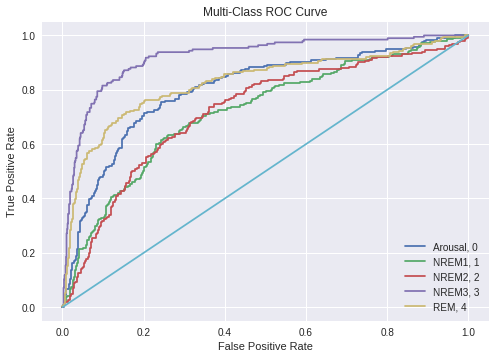

ROC_AUC for Micro: 0.7992717500000001


In [190]:
### Run whenever you want to train and validate your model ###

""" EPOCHS (int) is whatever number causes stabilization of validation loss and accuracy """

val_pred = model.predict(val_data)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(val_labels[:, i], val_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(val_labels.ravel(), val_pred.ravel())
roc_auc = metrics.auc(fpr["micro"], tpr["micro"])

print("ROC_AUC for Micro:", roc_auc)

## Submitting Your Model

After training your classifier, run it on the test data to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a pandas dataframe with 5 columns (classes) and 1000 rows (samples). Note that your predictions must follow the original test sample order (0.xz, 1.xz, 2.xz, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your pandas dataframe with the file number for each sample; 2) sort the dataframe using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions dataframe should be exported as an .xz file using dataframe.to_pickle() followed by files.download().

Example code of the prediction format and export is presented in the cell block below. 

In [188]:
### Run once after you have finished training your model ###

test_pred = model.predict(test_data)
test_output = np.ndarray(shape = (1000, 6))

""" Add column with file number """
for i in range(1000):
    test_output[i] = np.append(test_pred[i], test_order[i])
test_dataframe = pd.DataFrame(test_output)

""" Sort dataframe according to file number """
sorted_test_dataframe = test_dataframe.sort_values(by=[5])

""" Drop file number column """
processed_test_dataframe = sorted_test_dataframe.drop(sorted_test_dataframe.columns[5], axis=1)

print(test_dataframe.head(), '\n\n', sorted_test_dataframe.head(), '\n\n', processed_test_dataframe.head())

file = 'TeamEmojiS3.xz'
processed_test_dataframe.to_pickle(file)
files.download(file)

          0         1         2         3         4    5
0  0.001487  0.002328  0.044961  0.950379  0.000845  0.0
1  0.869711  0.029597  0.092623  0.000459  0.007610  1.0
2  0.511197  0.472423  0.009465  0.000057  0.006858  2.0
3  0.020970  0.030949  0.622934  0.017525  0.307623  3.0
4  0.436927  0.547333  0.009020  0.000125  0.006595  4.0 

           0         1         2         3         4    5
0  0.001487  0.002328  0.044961  0.950379  0.000845  0.0
1  0.869711  0.029597  0.092623  0.000459  0.007610  1.0
2  0.511197  0.472423  0.009465  0.000057  0.006858  2.0
3  0.020970  0.030949  0.622934  0.017525  0.307623  3.0
4  0.436927  0.547333  0.009020  0.000125  0.006595  4.0 

           0         1         2         3         4
0  0.001487  0.002328  0.044961  0.950379  0.000845
1  0.869711  0.029597  0.092623  0.000459  0.007610
2  0.511197  0.472423  0.009465  0.000057  0.006858
3  0.020970  0.030949  0.622934  0.017525  0.307623
4  0.436927  0.547333  0.009020  0.000125  0.00659

Your model will be evaluated on Area Under the ROC Curve (ROCAUC), Matthews Correlation Coefficient (MCC) and creativity. There will be a "winning" group for each of these categories.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

- **Area Under the ROC Curve (AUCROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." Below is the multi-class ROC curve for the example classifier. The AUCROC score should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

 ![alt text](https://image.ibb.co/g4pzST/ROCAUC.png)

- **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

 ![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

Using these metrics, the example classifier has the following scores on test data:
- AUCROC: 0.755
- MCC: 0.353
- Creativity: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUCROC and MCC metrics when evaluating your classifier.

In [0]:
test_pred = pd.DataFrame(model.predict(mocktest_data))
test_predict = test_pred.idxmax(axis=1)
test_labels = [ np.where(label==1)[0][0] for label in mocktest_labels]
test_labels_one_hot = pd.DataFrame(mocktest_labels)

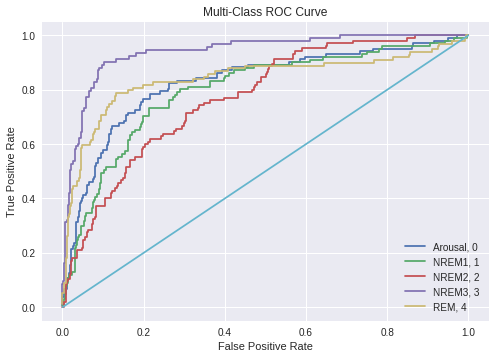

In [185]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc = metrics.auc(fpr["micro"], tpr["micro"])

In [0]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [187]:
print(roc_auc, mcc)

0.8388420000000001 0.4864884859989021
